In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from models.pytorch_model import OrigamiNetwork
import matplotlib.pyplot as plt
import numpy as np
from jeffutils.utils import stack_trace, reimport
reimport('reimport model.pytorch_model OrigamiNetwork', globals())

/Users/jeddybennett/Documents/FoldAndCutNetworks/models/pytorch_model.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y)
Val Accuracy: 0.9611: 100%|██████████| 1000/1000 [01:08<00:00, 14.60it/s]

Test Accuracy: 0.9667


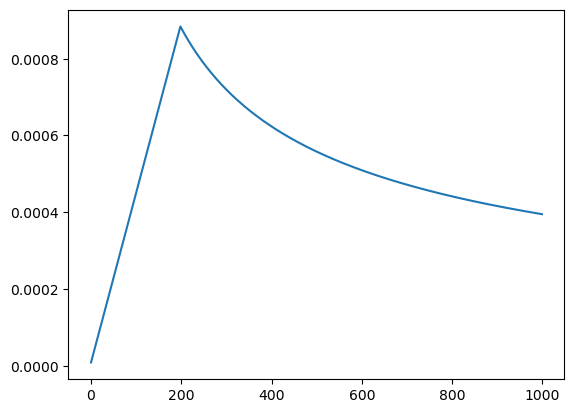

In [2]:
digits = load_digits()
X = digits.data 
y = digits.target

X = X.astype('float32')
y = y.astype('int64')

X /= 16.0 


X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=42, stratify=y_train_full
)

model = OrigamiNetwork(
    n_layers=3,
    width=X.shape[1],
    epochs=1000,
    learning_rate=0.1,
    sigmoid=True,
    crease=5,
    optimizer_type="adam",
    batch_size=32,
    lr_schedule=True
)

# Train the model
model.fit(X_train, y_train, X_val, y_val)

# Evaluate on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

plt.plot(model.learning_rates)

In [25]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load data
iris = load_iris()
X = iris.data
y = iris.target

# Preprocess
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Initialize and train model
model = OrigamiNetwork(n_layers=1, width=3, epochs=300,learning_rate = 0.01, optimizer_type = 'adam', lr_schedule=False)
model.fit(X_train, y_train, X_val, y_val)

#Evaluate on validation set
y_pred = model.predict(X_val)
test_accuracy = accuracy_score(y_val, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

/Users/jeddybennett/Documents/FoldAndCutNetworks/models/pytorch_model.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y)
Val Accuracy: 0.9667: 100%|██████████| 300/300 [00:02<00:00, 134.48it/s]

Test Accuracy: 0.9667


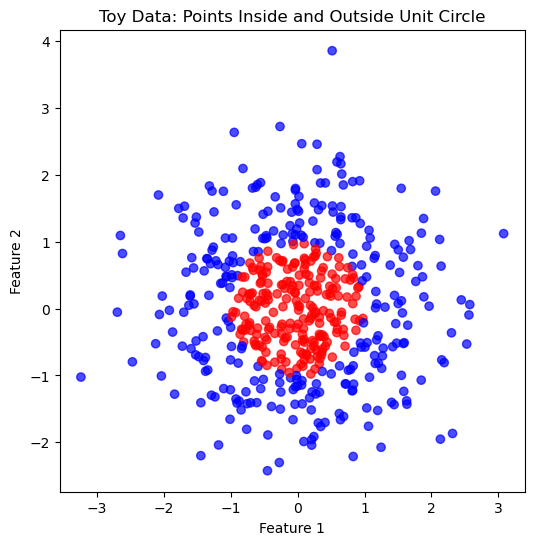

In [55]:
# Set random seed for reproducibility
np.random.seed(42)

# Number of samples
n_samples = 500

width = 2
# Generate random points in 2D space
X = np.random.randn(n_samples, width)

# Labels: Points inside the unit circle are labeled True (1), others False (0)
y = (np.linalg.norm(X, axis=1) < 1).astype(int)

plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', alpha=0.7)
plt.title('Toy Data: Points Inside and Outside Unit Circle')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.axis('equal')
plt.show()

In [56]:
# Split data: 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [57]:
layers = 8
model = OrigamiNetwork(
    n_layers=layers,
    width=2,
    epochs=1000,
    learning_rate=0.01,
    sigmoid=False,  # Set to True if you want to use the sigmoid fold
    crease=5,
    optimizer_type='sgd',  # Use 'sgd' or 'adam'
    batch_size=32,
    leak = 0.1,
    lr_schedule=False
)

In [58]:
model.fit(X_train,y_train,X_val,y_val)

KeyboardInterrupt: 

Visualizing folds at Layer 0


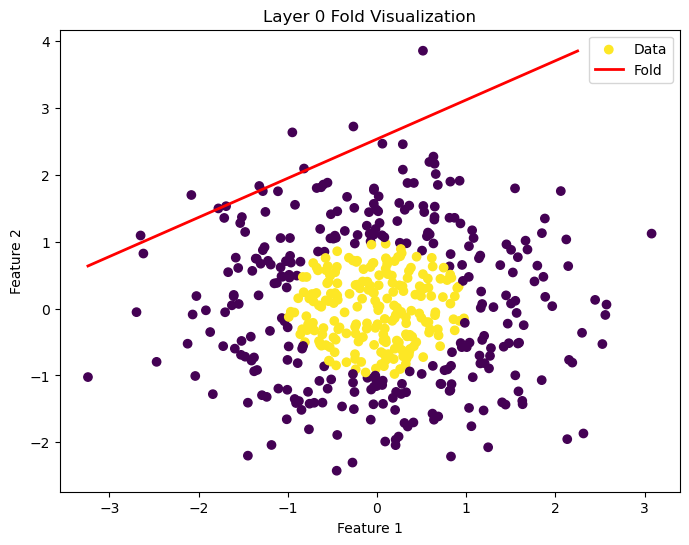

Visualizing folds at Layer 1


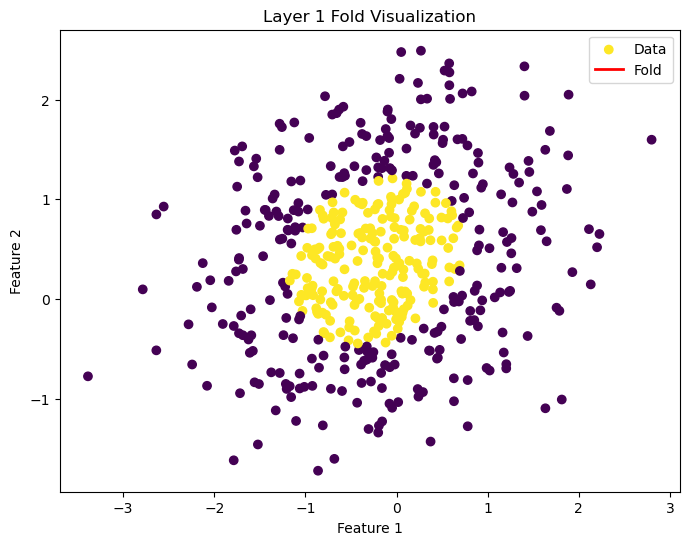

Visualizing folds at Layer 2


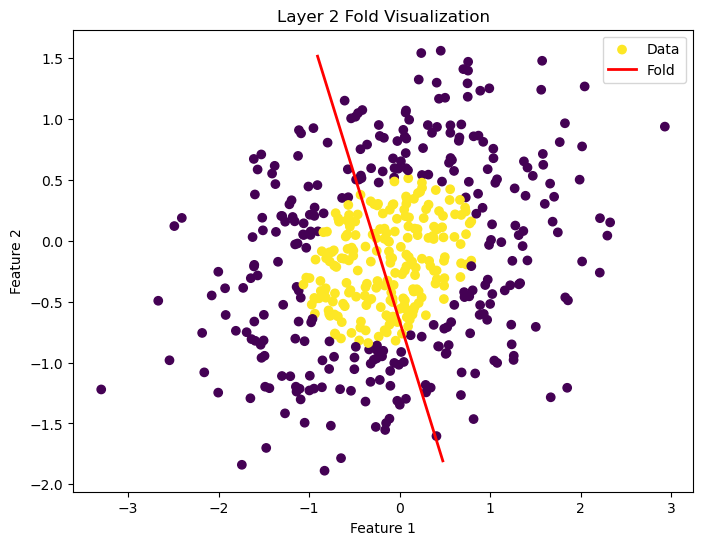

Visualizing folds at Layer 3


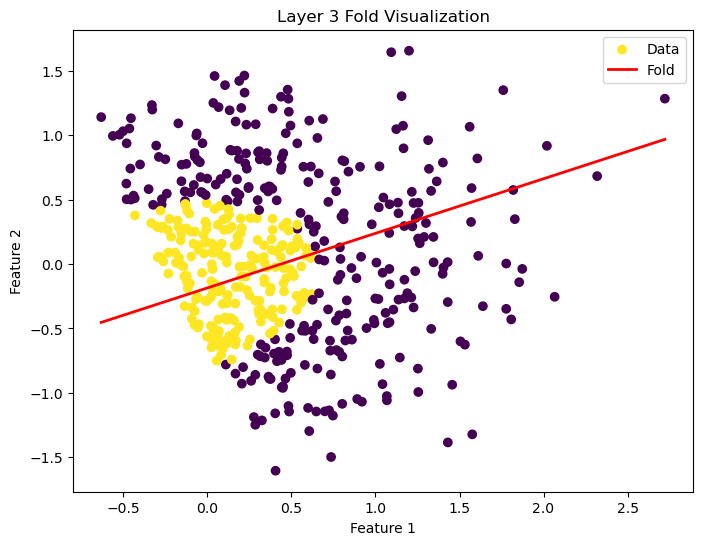

Visualizing folds at Layer 4


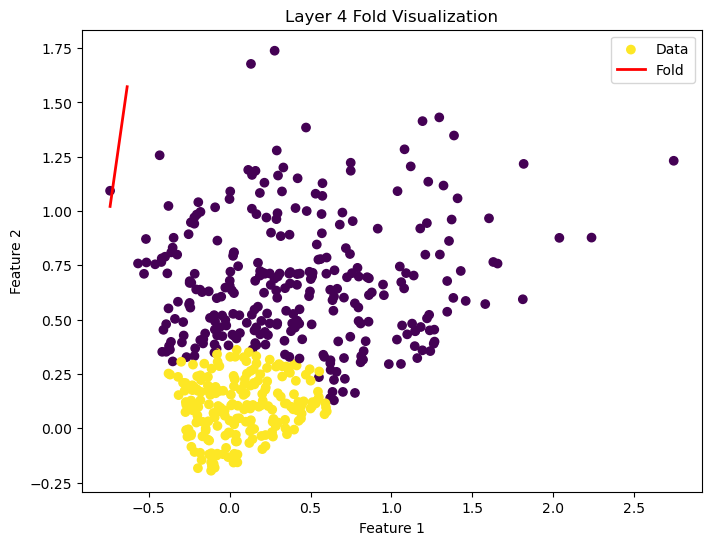

Visualizing folds at Layer 5


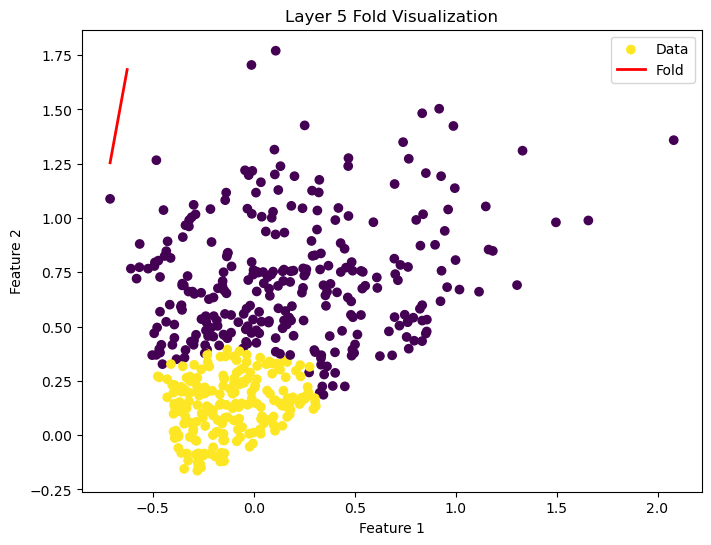

Visualizing folds at Layer 6


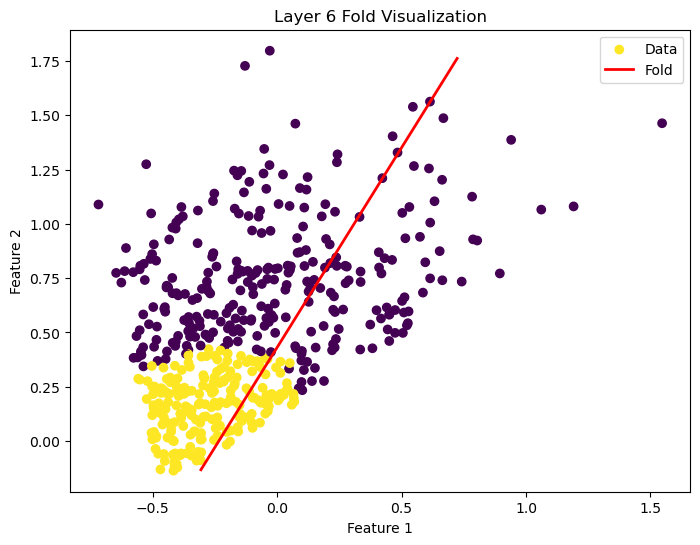

Visualizing folds at Layer 7


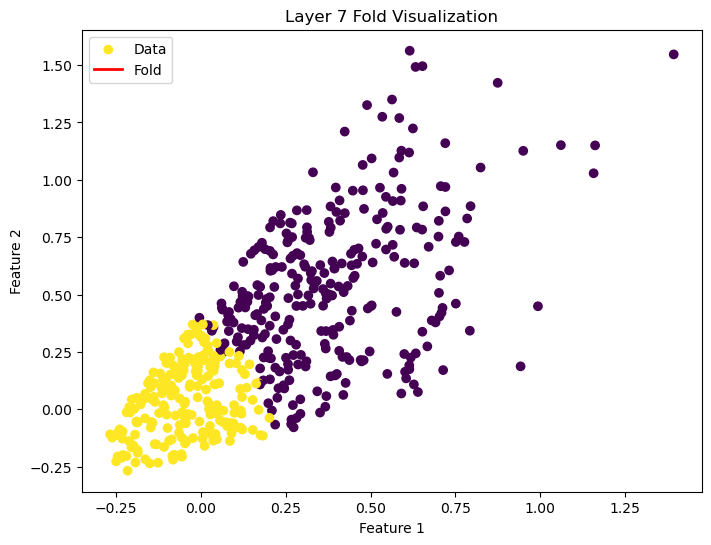

Visualizing folds at Layer 8


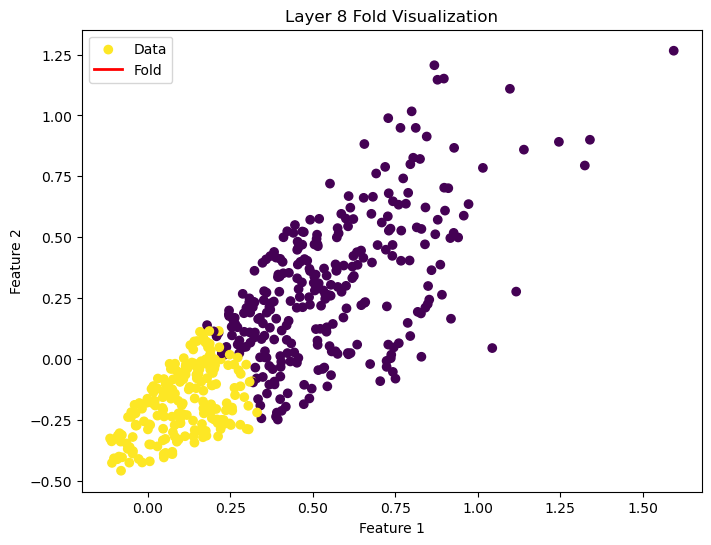

Visualizing folds at Layer 9


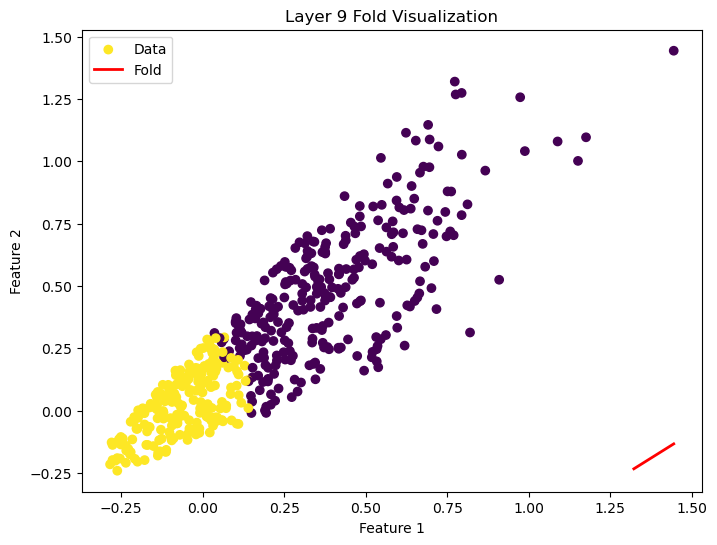

Visualizing folds at Layer 10


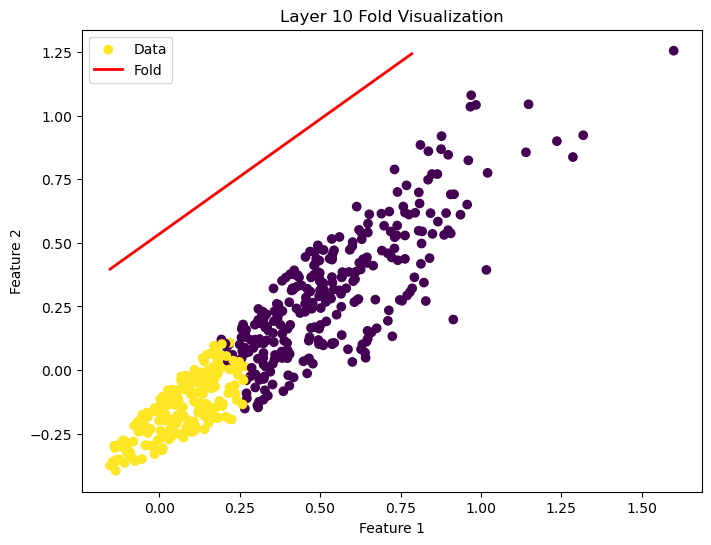

Visualizing folds at Layer 11


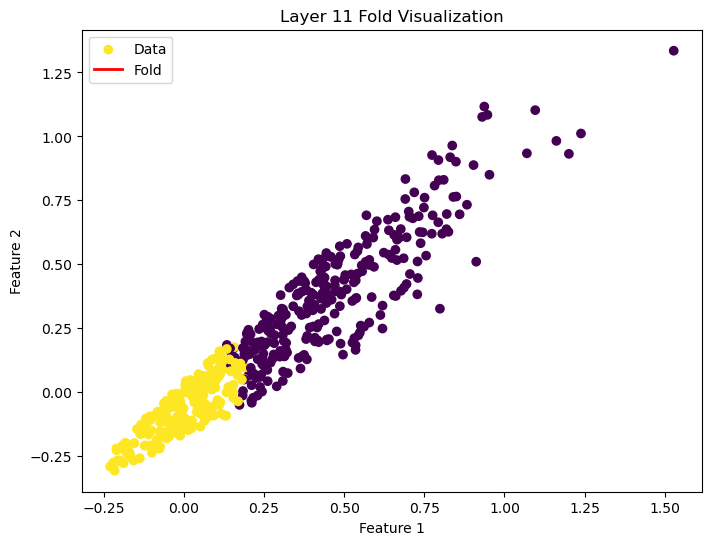

Visualizing folds at Layer 12


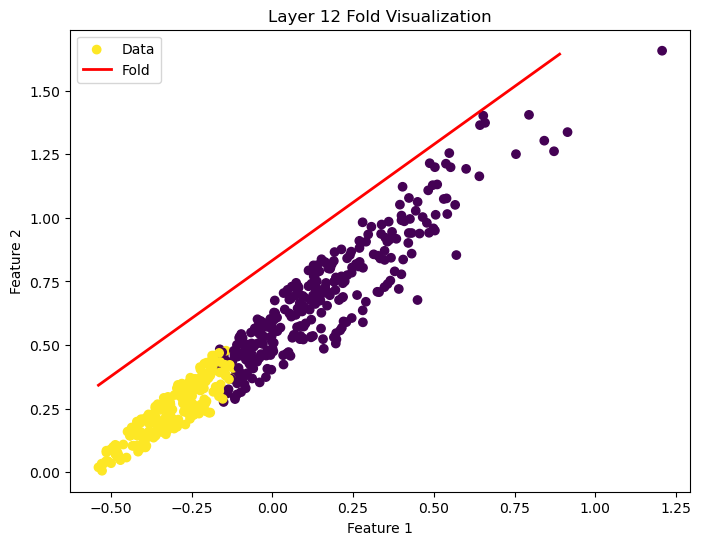

Visualizing folds at Layer 13


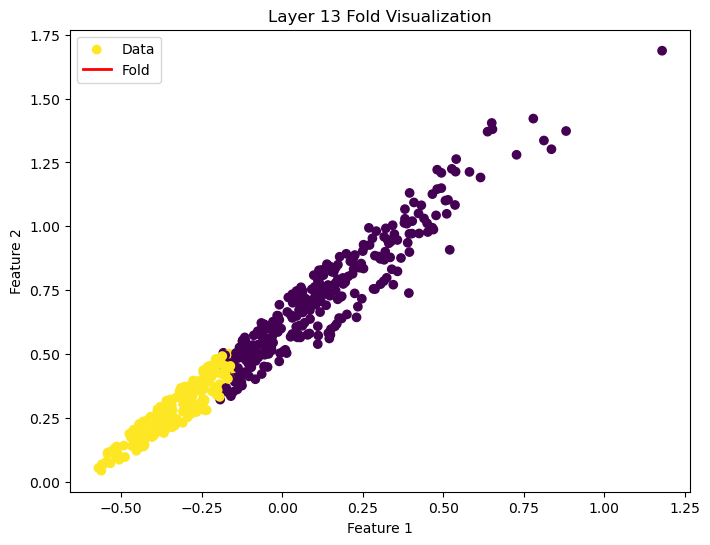

Visualizing folds at Layer 14


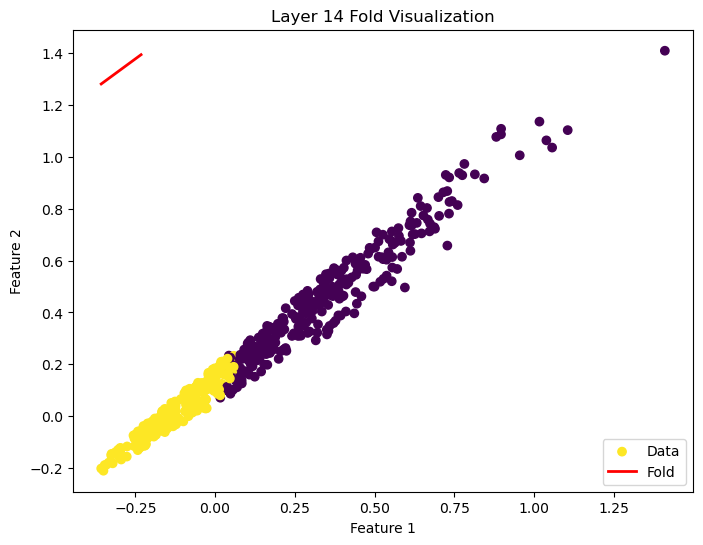

Visualizing folds at Layer 15


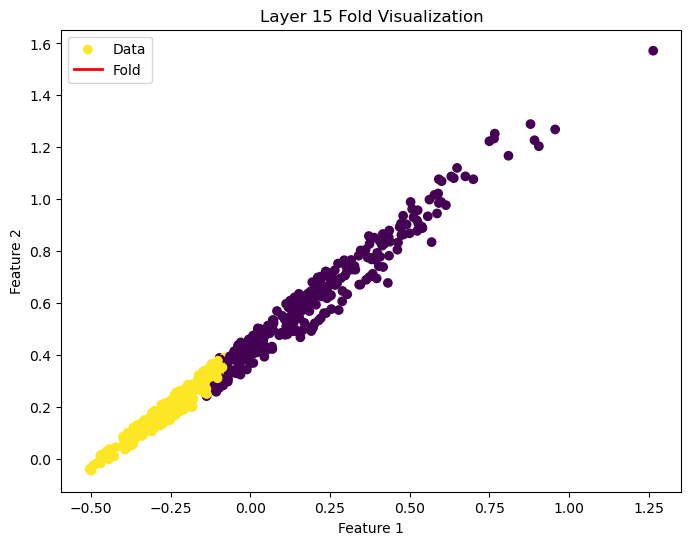

Visualizing folds at Layer 16


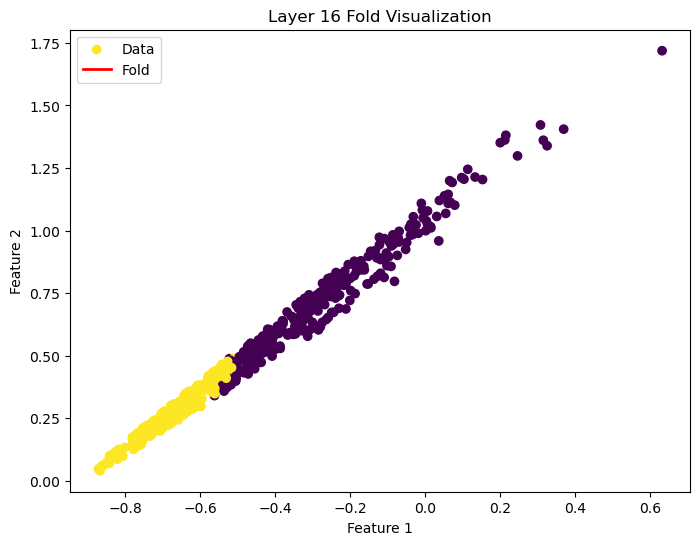

Visualizing folds at Layer 17


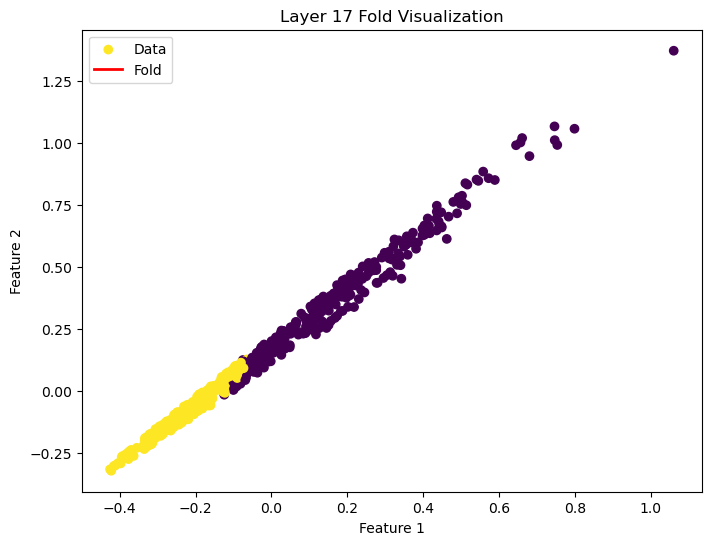

Visualizing folds at Layer 18


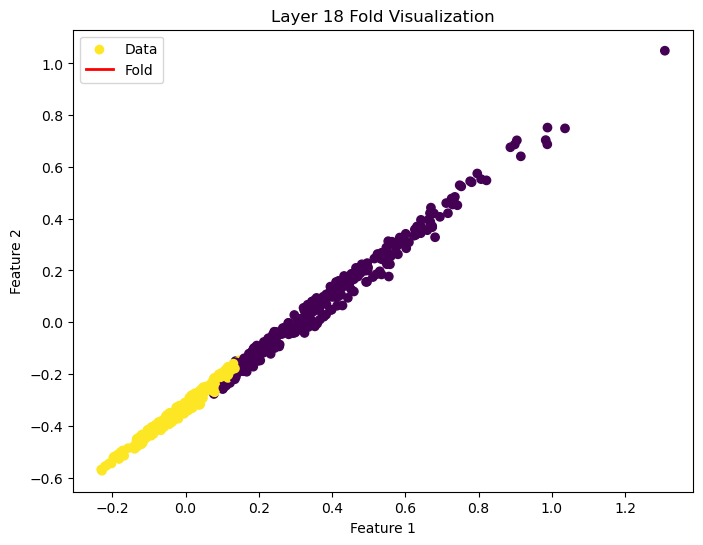

Visualizing folds at Layer 19


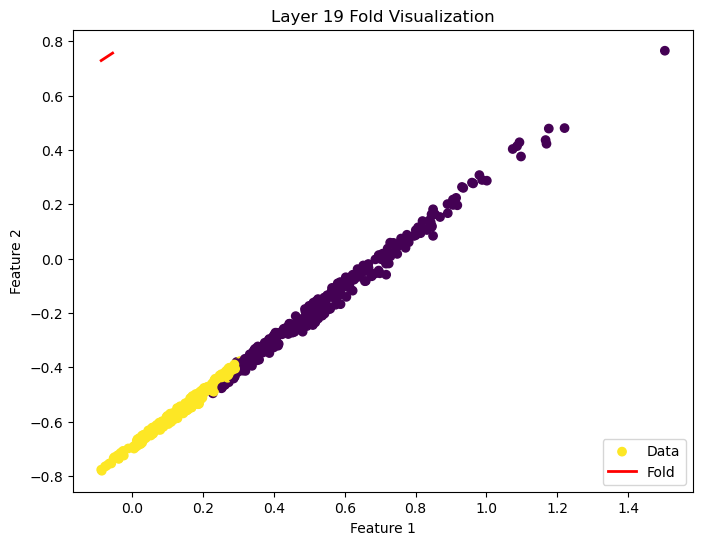

In [37]:
# Visualize folds at each layer
for layer_index in range(layers):
    print(f"Visualizing folds at Layer {layer_index}")
    model.plot_folds(X, y, layer_index=layer_index, use_plotly=False)

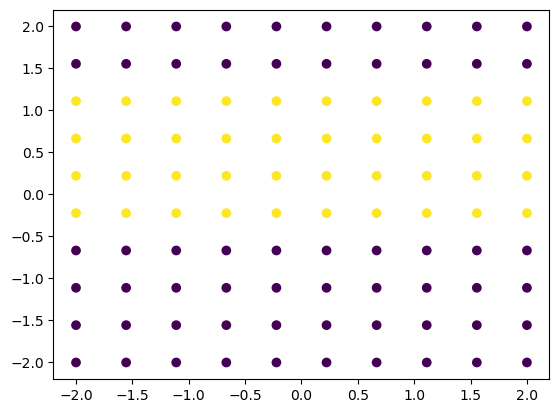

In [38]:
def layer_sam(D, n):
    scales = (D@n)/np.dot(n, n)
    mask = scales > 1
    return D + mask[:,np.newaxis] * (2*n - (2 * np.outer(scales, n)))
fv1 = np.array([0,.5])
size = 10
X1, X2 = np.meshgrid(np.linspace(-2,2,size), np.linspace(-2,2,size))
pairs = np.concatenate((X1.reshape(-1,1), X2.reshape(-1,1)), axis=1)
Y = layer_sam(pairs, fv1)[:,1] > -.5
plt.scatter(pairs[:,0], pairs[:,1], c=Y)

In [42]:
model.fit(pairs, Y)

Training: 100%|██████████| 1000/1000 [00:10<00:00, 94.62it/s]


Visualizing folds at Layer 0


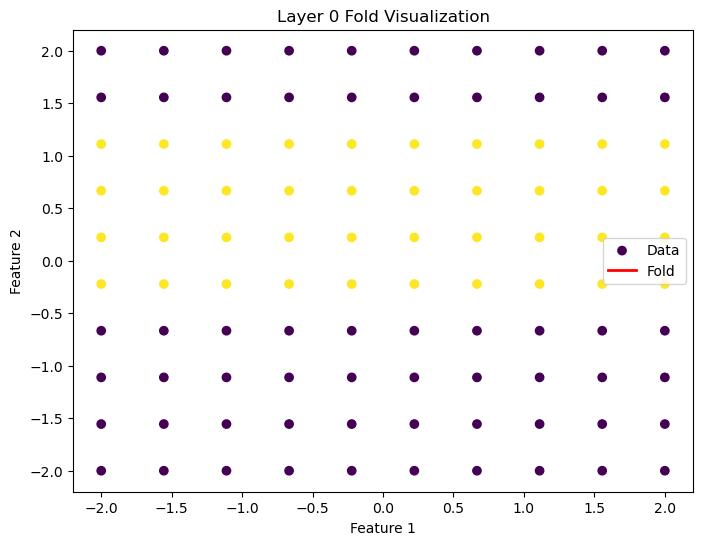

Visualizing folds at Layer 1


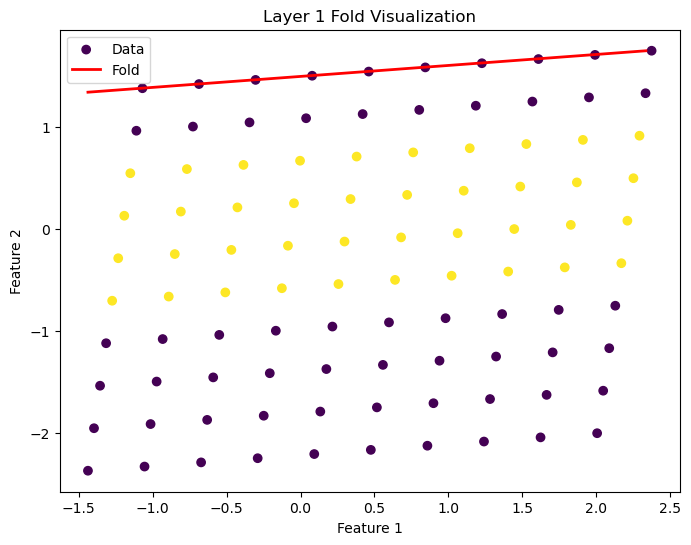

Visualizing folds at Layer 2


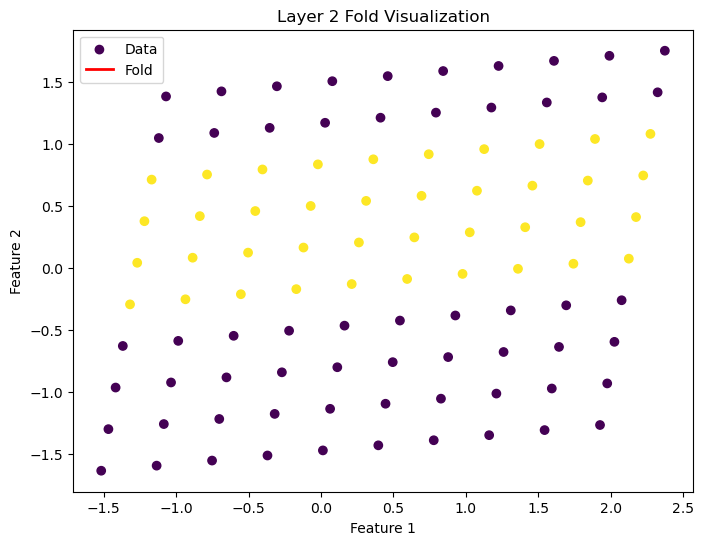

Visualizing folds at Layer 3


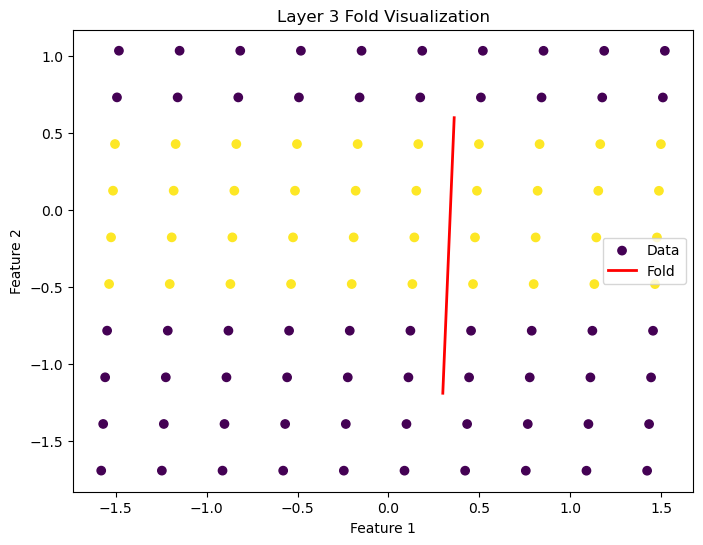

Visualizing folds at Layer 4


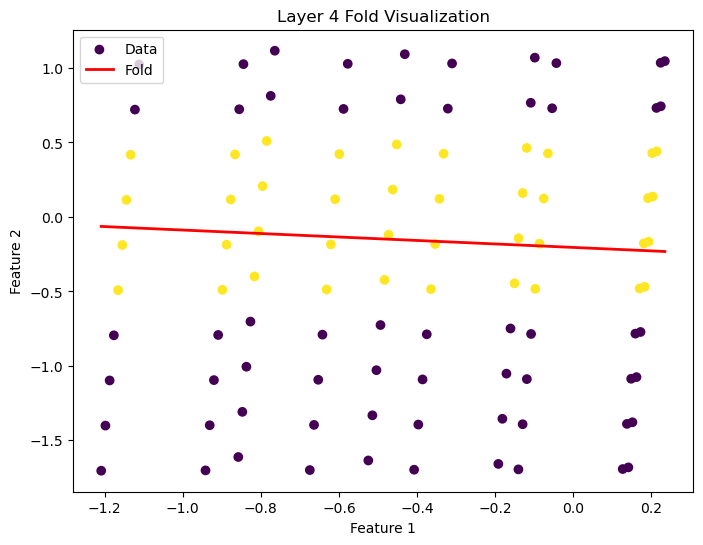

In [43]:
# Visualize folds at each layer
for layer_index in range(layers):
    print(f"Visualizing folds at Layer {layer_index}")
    model.plot_folds(pairs, Y, layer_index=layer_index, use_plotly=False)